### FCC Data, Community Areas

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Importing Chicago FCC data

First, we use the FCC IL Dec 2020 csv file (which can be found [here](https://us-fcc.app.box.com/v/IL-Dec2020-v1)). Since it is a large file and we only want data on Chicago, we filter for Cook County data only and then export it as a new csv file which is saved in the "data" folder. **DO NOT RUN THE FOLLOWING CHUNKS OF CODE!!!**

In [ ]:
# FCC IL

fcc_df = pd.read_csv("data/IL-Fixed-Dec2020-v1.csv",
                     index_col=0,parse_dates=[0])

In [ ]:
#changing BlockCode column to string type

fcc_df['BlockCode']=fcc_df['BlockCode'].astype(str)

In [ ]:
# Extracting state, county, tract, block numbers from BlockCode column
# IL state=17
# Cook County=031

fcc_df['state'] = fcc_df['BlockCode'].str[:2]
fcc_df['county'] = fcc_df['BlockCode'].str[2:5]
fcc_df['tract'] = fcc_df['BlockCode'].str[5:11]
fcc_df['block'] = fcc_df['BlockCode'].str[-4:]

In [ ]:
# Filtering for Cook County only 
# 763788 rows

chi_fcc = fcc_df[(fcc_df.county == "031")]

In [ ]:
# dropping columns we don't need to make the file smaller

chi_fcc=chi_fcc[['ProviderName', 'Consumer', 
                 'MaxAdDown','MaxAdUp','tract']]
chi_fcc['tract']=chi_fcc['tract'].astype(float)

In [ ]:
# export final dataframe to csv file

chi_fcc.to_csv(r'data/chi_fcc.csv', index = False)

In [ ]:
# final dataframe looks like this
chi_fcc.head(5)

Run this code to load the Chicago FCC data.  

In [2]:
# Chicago FCC data

chi_fcc = pd.read_csv("data/chi_fcc.csv",index_col=0,parse_dates=[0])
chi_fcc.head(5)

,Consumer,MaxAdDown,MaxAdUp,tract
ProviderName,,,,
"TOWERSTREAM, INC.",0,0.0,0.0,20702.0
"TOWERSTREAM, INC.",0,0.0,0.0,80300.0
"TOWERSTREAM, INC.",0,0.0,0.0,81000.0
"TOWERSTREAM, INC.",0,0.0,0.0,81300.0
"TOWERSTREAM, INC.",0,0.0,0.0,81500.0


In [25]:
test = pd.read_csv("data/chi_fcc.csv",index_col=0,parse_dates=[0])

In [26]:
test.filter('Consumer'==1)

,Consumer,MaxAdDown,MaxAdUp
tract,,,
20702.0,0,0.0,0.0
80300.0,0,0.0,0.0
81000.0,0,0.0,0.0
81300.0,0,0.0,0.0
81500.0,0,0.0,0.0
...,...,...,...
980100.0,1,2.0,1.3
980100.0,1,2.0,1.3
980100.0,1,2.0,1.3


In [3]:
chi_fcc.columns

Index(['Consumer', 'MaxAdDown', 'MaxAdUp', 'tract'], dtype='object')

In [6]:
len(chi_fcc)

763788

In [10]:
np.mean(chi_fcc.Consumer)

0.8352095083976182

In [11]:
np.mean(chi_fcc.MaxAdDown)

190.1690753821718

In [12]:
np.median(chi_fcc.MaxAdDown)

25.0

(array([3.20361e+05, 2.33605e+05, 1.16500e+04, 1.15220e+04, 0.00000e+00,
        5.17380e+04, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.29000e+02, 0.00000e+00, 6.00000e+00, 0.00000e+00, 0.00000e+00,
        8.20000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.52300e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.26159e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
         220,  240,  260,  280,  300,  320,  340,  360,  380,

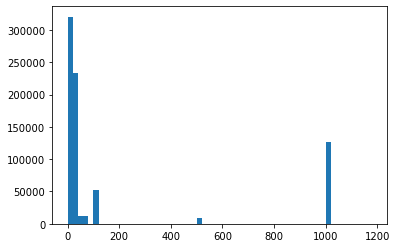

In [17]:
plt.hist(chi_fcc.MaxAdDown,bins=range(0,1200,20))

(array([2.42056e+05, 1.23040e+04, 4.58400e+03, 6.14170e+04, 7.22000e+02,
        1.47156e+05, 5.00000e+00, 8.57220e+04, 0.00000e+00, 7.00000e+00,
        1.16430e+04, 0.00000e+00, 0.00000e+00, 2.78400e+03, 0.00000e+00,
        8.73800e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        5.17380e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195]),
 <BarContainer object of 39 artists>)

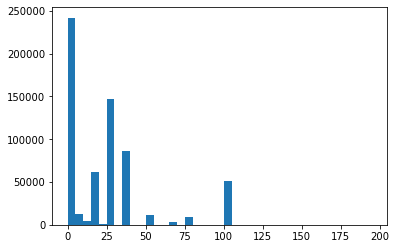

In [18]:
plt.hist(chi_fcc.MaxAdDown,bins=range(0,200,5))

In [22]:
import data_pipeline.spatial_operations as spatial

In [24]:
variables = {'MaxAdDown' : 'pop mean', 'MaxAdUp' : 'pop mean'}
comm_fcc = spatial.aggregate(chi_fcc,variables,'community_area','tract')

KeyboardInterrupt: 